## Packages

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def load_data(path):
    train_dataset = h5py.File(path+'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Dataset

To be familiar with the dataset, load the data by running the cell below.

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('C:\\Users\\Taha Yunus\\PycharmProjects\\matplo\\dataset') # you need to change your dataset path

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 1. It's a cat picture.


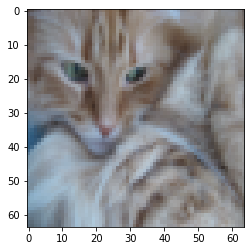

In [4]:
# Example of a picture
index = 2
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [7]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7        # number of neurons
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [8]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":
    """
    np.random.seed(1)
    parameters = {}

    parameters["W1"] = 0.10*np.random.randn(n_h,n_x)
    parameters["b1"] = np.full((n_h,1),0)
    parameters["W2"] = 0.10*np.random.randn(n_h,n_h)
    parameters["b2"] = np.full((n_h,1),0)
    
    return parameters

In [9]:
def linear_activation_forward(X,parameters):
    """
    Implement the forward propagation

    Arguments:
    X -- input data:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":

    Returns:
    AL -- output of the forward propogation
    """
    def sigmoid(Z):
        A = 1/(1+np.exp(-Z))
        return A
    def ReLU(Z):
        return np.maximum(Z, 0)
    
    Z1 = parameters["W1"].dot(X) + parameters["b1"]
    A1 = ReLU(Z1)
    Z2 = parameters["W2"].dot(A1) + parameters["b2"]
    AL = sigmoid(Z2)
    return AL,Z1

In [10]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cost
    """
    m=Y.shape[1]
    cost = (- 1 / m) * np.sum(Y * np.log(AL) + (1 - Y) * (np.log(1 - AL)))

    #here y is train_y
    
    
    return cost

In [11]:
def linear_activation_backward(X,cost,Y,AL,Z1,parameters):
    """
    Implement the backward propagation
    
    Arguments:
    X -- input data
    cost -- cost
    
    Returns:
    grads --  A dictionary with the gradients
             grads["dW1"]
             grads["db1"]
             grads["dW2"]
             grads["db2"]
    """
    """Y is here output data to calculate difference between our output and real value train_y"""
    def ReLU_deriv(Z):
        return Z > 0
    m=X.shape[1]
    grads=dict()
    grads["dZ2"]=AL - Y
    grads["dW2"] = 1 / m * grads["dZ2"].dot(AL.T)
    grads["db2"] = 1 / m * np.sum(grads["dZ2"])
    grads["dZ1"] = parameters["W2"].T.dot(grads["dZ2"]) * ReLU_deriv(Z1)
    grads["dW1"] = 1 / m * grads["dZ1"].dot(X.T)
    grads["db1"] = 1 / m * np.sum(grads["dZ1"])
    
        

    
    return grads

In [12]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
             parameters["W1"]
             parameters["b1"]
             parameters["W2"]
             parameters["b2"]
    """
    alpha=learning_rate
    parameters["W1"] = parameters["W1"] - alpha * grads["dW1"]
    parameters["b1"] = parameters["b1"] - alpha * grads["db1"]    
    parameters["W2"] = parameters["W2"] - alpha * grads["dW2"]  
    parameters["b2"] = parameters["b2"] - alpha * grads["db2"] 
    
    
    
    return parameters





In [13]:
def predict(test_x, test_y,parameters,train=1):
    """
    Predict test data
    test_x -- test data
    test_y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    
    Returns:
    accuracy -- accuracy of your model
    
    """
    m = test_x.shape[1]
    Y_prediction = np.zeros((1,m))
    
    AL,Z1=linear_activation_forward(test_x,parameters)
    for i in range(AL.shape[1]):
        if AL[0,i] <= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
        pass
      
    if train==1:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - test_y)) * 100))
    else:
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - test_y))*100))
    accuracy=100 - np.mean(np.abs(Y_prediction - test_y)) * 100
    return accuracy

In [14]:
def plot_loss(costs,learning_rate):
    """
    Plot loss
    costs - cost of each iteration
    
    """ 
    costs = np.squeeze(costs)
    plt.plot(costs)
    plt.ylabel("cost")
    plt.xlabel("iterations (per hundreds)")
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    

In [15]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### 
        AL,Z1 = linear_activation_forward(train_x,parameters)# fill here
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### 
        cost = compute_cost(AL, Y)# fill here
        ### END CODE HERE ###
        
        
        # Backward propagation.
        ### START CODE HERE ### 
        grads = linear_activation_backward(X,cost,Y,AL,Z1,parameters)# fill here
        ### END CODE HERE ###

        
        # Update parameters.
        ### START CODE HERE ### 
        parameters = update_parameters(parameters, grads, learning_rate)# fill here
        ### END CODE HERE ###
        
        # Print the cost every 100 training e0xample
        if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)

    return parameters, costs 



Cost after iteration 0: 6.301796012604849
Cost after iteration 100: 4.541218905467464
Cost after iteration 200: 4.454789879918927
Cost after iteration 300: 4.404025252298553
Cost after iteration 400: 4.377772933899916
Cost after iteration 500: 4.3656341395226175
Cost after iteration 600: 4.359778397767793
Cost after iteration 700: 4.359629059647524
Cost after iteration 800: 4.349989933121976
Cost after iteration 900: 4.338236014394213
Cost after iteration 1000: 4.322568501469559
Cost after iteration 1100: 4.2941591586357335
Cost after iteration 1200: 4.243837195390471
Cost after iteration 1300: 4.1440445282398
Cost after iteration 1400: 3.9591590467347997
Cost after iteration 1500: 3.7390282813913407
Cost after iteration 1600: 3.5048003240991195
Cost after iteration 1700: 3.2869908390530194
Cost after iteration 1800: 3.077388687481517
Cost after iteration 1900: 2.8826424242018285
Cost after iteration 2000: 2.6768557303057126
Cost after iteration 2100: 2.476298794238136
Cost after itera

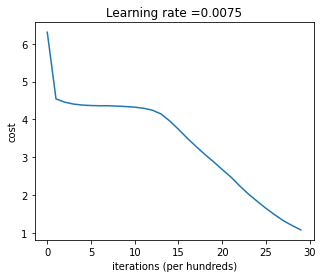

train accuracy: 98.08612440191388 %
test accuracy: 74.0 %


In [16]:
def main():
    """Main function
    You need to combine all functions in the main function"""
    
    
    x=two_layer_model(train_x,train_y,layers_dims)
    plot_loss(x[1],learning_rate = 0.0075)
    predict(train_x,train_y,x[0])
    predict(test_x,test_y,x[0],train=0)
main()
    